In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-18 14:10:37.155982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 14:10:40.560896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-18 14:10:40.561110: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

2.11.0


In [2]:
# !git clone https://github.com/EricMartinezIllamola/asl-global.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "asl-global/asl-global"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
tf.config.experimental.list_physical_devices()

2023-09-18 14:10:44.778220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 14:10:44.793119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 14:10:44.795993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 4966 images belonging to 34 classes.
Found 1048 images belonging to 34 classes.
Found 1088 images belonging to 34 classes.


In [10]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-18 14:10:45.624338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 14:10:45.626030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 14:10:45.629436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 14:10:45.632100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
##DEFINIMOS EL MODELO
num_classes = 34
epochs = 125

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(2048, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [12]:
## EJECUCION DEL MODELO
# with tf.device("/CPU:0"):
# with tf.device("/GPU:0"):
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

metric = 'val_accuracy'

checkpointer = ModelCheckpoint(filepath='model-02', verbose=1, save_best_only=True,
                               monitor = metric, mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, validation_data = valid_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/125


2023-09-18 14:10:51.526364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-09-18 14:10:53.702045: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb0ab613380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-18 14:10:53.702101: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-09-18 14:10:53.781865: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


156/156 [==============================] - ETA: 0s - loss: 11.7054 - accuracy: 0.0356
Epoch 1: val_accuracy improved from -inf to 0.06298, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 24s 114ms/step - loss: 11.7054 - accuracy: 0.0356 - val_loss: 11.5881 - val_accuracy: 0.0630 - lr: 0.0010
Epoch 2/125
156/156 [==============================] - ETA: 0s - loss: 11.4592 - accuracy: 0.0836
Epoch 2: val_accuracy improved from 0.06298 to 0.12977, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 111ms/step - loss: 11.4592 - accuracy: 0.0836 - val_loss: 11.2018 - val_accuracy: 0.1298 - lr: 0.0010
Epoch 3/125
156/156 [==============================] - ETA: 0s - loss: 11.0194 - accuracy: 0.1418
Epoch 3: val_accuracy improved from 0.12977 to 0.19943, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 108ms/step - loss: 11.0194 - accuracy: 0.1418 - val_loss: 10.7390 - val_accuracy: 0.1994 - lr: 0.0010
Epoch 4/125
156/156 [==============================] - ETA: 0s - loss: 10.5874 - accuracy: 0.2247
Epoch 4: val_accuracy improved from 0.19943 to 0.34828, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 112ms/step - loss: 10.5874 - accuracy: 0.2247 - val_loss: 10.2109 - val_accuracy: 0.3483 - lr: 0.0010
Epoch 5/125
156/156 [==============================] - ETA: 0s - loss: 10.2104 - accuracy: 0.3153
Epoch 5: val_accuracy did not improve from 0.34828
156/156 [==============================] - 12s 77ms/step - loss: 10.2104 - accuracy: 0.3153 - val_loss: 10.0674 - val_accuracy: 0.3282 - lr: 0.0010
Epoch 6/125
156/156 [==============================] - ETA: 0s - loss: 9.8251 - accuracy: 0.4052
Epoch 6: val_accuracy improved from 0.34828 to 0.49523, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 106ms/step - loss: 9.8251 - accuracy: 0.4052 - val_loss: 9.5159 - val_accuracy: 0.4952 - lr: 0.0010
Epoch 7/125
156/156 [==============================] - ETA: 0s - loss: 9.5251 - accuracy: 0.4895
Epoch 7: val_accuracy improved from 0.49523 to 0.60305, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 111ms/step - loss: 9.5251 - accuracy: 0.4895 - val_loss: 9.1675 - val_accuracy: 0.6031 - lr: 0.0010
Epoch 8/125
156/156 [==============================] - ETA: 0s - loss: 9.2325 - accuracy: 0.5546
Epoch 8: val_accuracy improved from 0.60305 to 0.64122, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 106ms/step - loss: 9.2325 - accuracy: 0.5546 - val_loss: 8.9762 - val_accuracy: 0.6412 - lr: 0.0010
Epoch 9/125
156/156 [==============================] - ETA: 0s - loss: 9.0124 - accuracy: 0.6055
Epoch 9: val_accuracy improved from 0.64122 to 0.67271, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 110ms/step - loss: 9.0124 - accuracy: 0.6055 - val_loss: 8.7800 - val_accuracy: 0.6727 - lr: 0.0010
Epoch 10/125
156/156 [==============================] - ETA: 0s - loss: 8.8251 - accuracy: 0.6504
Epoch 10: val_accuracy improved from 0.67271 to 0.70420, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 106ms/step - loss: 8.8251 - accuracy: 0.6504 - val_loss: 8.6596 - val_accuracy: 0.7042 - lr: 0.0010
Epoch 11/125
156/156 [==============================] - ETA: 0s - loss: 8.2807 - accuracy: 0.7592
Epoch 14: val_accuracy did not improve from 0.79008
156/156 [==============================] - 12s 77ms/step - loss: 8.2807 - accuracy: 0.7592 - val_loss: 8.8017 - val_accuracy: 0.6088 - lr: 0.0010
Epoch 15/125
156/156 [==============================] - ETA: 0s - loss: 8.1679 - accuracy: 0.7888
Epoch 15: val_accuracy did not improve from 0.79008
156/156 [==============================] - 12s 76ms/step - loss: 8.1679 - accuracy: 0.7888 - val_loss: 8.1433 - val_accuracy: 0.7882 - lr: 0.0010
Epoch 16/125
156/156 [==============================] - ETA: 0s - loss: 8.0823 - accuracy: 0.7980
Epoch 16: val_accuracy improved from 0.79008 to 0.82252, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 108ms/step - loss: 8.0823 - accuracy: 0.7980 - val_loss: 7.9757 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 17/125
156/156 [==============================] - ETA: 0s - loss: 7.9994 - accuracy: 0.8033
Epoch 17: val_accuracy improved from 0.82252 to 0.85019, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 108ms/step - loss: 7.9994 - accuracy: 0.8033 - val_loss: 7.8644 - val_accuracy: 0.8502 - lr: 0.0010
Epoch 18/125
156/156 [==============================] - ETA: 0s - loss: 7.9233 - accuracy: 0.8147
Epoch 18: val_accuracy did not improve from 0.85019
156/156 [==============================] - 12s 76ms/step - loss: 7.9233 - accuracy: 0.8147 - val_loss: 7.8533 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 19/125
156/156 [==============================] - ETA: 0s - loss: 7.8311 - accuracy: 0.8329
Epoch 19: val_accuracy improved from 0.85019 to 0.85592, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 109ms/step - loss: 7.8311 - accuracy: 0.8329 - val_loss: 7.7821 - val_accuracy: 0.8559 - lr: 0.0010
Epoch 20/125
156/156 [==============================] - ETA: 0s - loss: 7.7864 - accuracy: 0.8329
Epoch 20: val_accuracy did not improve from 0.85592
156/156 [==============================] - 12s 77ms/step - loss: 7.7864 - accuracy: 0.8329 - val_loss: 7.7331 - val_accuracy: 0.8397 - lr: 0.0010
Epoch 21/125
156/156 [==============================] - ETA: 0s - loss: 7.7171 - accuracy: 0.8417
Epoch 21: val_accuracy improved from 0.85592 to 0.86641, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 111ms/step - loss: 7.7171 - accuracy: 0.8417 - val_loss: 7.6290 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 22/125
156/156 [==============================] - ETA: 0s - loss: 7.6373 - accuracy: 0.8474
Epoch 22: val_accuracy did not improve from 0.86641
156/156 [==============================] - 12s 76ms/step - loss: 7.6373 - accuracy: 0.8474 - val_loss: 7.6098 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 23/125
156/156 [==============================] - ETA: 0s - loss: 7.5654 - accuracy: 0.8625
Epoch 23: val_accuracy did not improve from 0.86641
156/156 [==============================] - 13s 81ms/step - loss: 7.5654 - accuracy: 0.8625 - val_loss: 7.6070 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 24/125
156/156 [==============================] - ETA: 0s - loss: 7.5154 - accuracy: 0.8651
Epoch 24: val_accuracy did not improve from 0.86641
156/156 [==============================] - 12s 77ms/step - loss: 7.5154 - accuracy: 0.8651 - val_loss: 7.5459 -

INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 107ms/step - loss: 7.3246 - accuracy: 0.8794 - val_loss: 7.2819 - val_accuracy: 0.9027 - lr: 0.0010
Epoch 28/125
155/156 [============================>.] - ETA: 0s - loss: 7.2859 - accuracy: 0.8821
Epoch 28: val_accuracy did not improve from 0.90267
156/156 [==============================] - 12s 76ms/step - loss: 7.2857 - accuracy: 0.8822 - val_loss: 7.3817 - val_accuracy: 0.8406 - lr: 0.0010
Epoch 29/125
156/156 [==============================] - ETA: 0s - loss: 7.2354 - accuracy: 0.8832
Epoch 29: val_accuracy did not improve from 0.90267
156/156 [==============================] - 12s 78ms/step - loss: 7.2354 - accuracy: 0.8832 - val_loss: 7.2182 - val_accuracy: 0.8788 - lr: 0.0010
Epoch 30/125
156/156 [==============================] - ETA: 0s - loss: 7.1684 - accuracy: 0.8882
Epoch 30: val_accuracy did not improve from 0.90267
156/156 [==============================] - 12s 77ms/step - loss: 7.1684 - accuracy: 0.8882 - val_loss: 7.1514 -

INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 110ms/step - loss: 6.8476 - accuracy: 0.8989 - val_loss: 6.8144 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 38/125
156/156 [==============================] - ETA: 0s - loss: 6.7884 - accuracy: 0.9066
Epoch 38: val_accuracy did not improve from 0.91126
156/156 [==============================] - 12s 76ms/step - loss: 6.7884 - accuracy: 0.9066 - val_loss: 6.8332 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 39/125
156/156 [==============================] - ETA: 0s - loss: 6.7167 - accuracy: 0.9150
Epoch 39: val_accuracy did not improve from 0.91126
156/156 [==============================] - 12s 77ms/step - loss: 6.7167 - accuracy: 0.9150 - val_loss: 6.7259 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 40/125
156/156 [==============================] - ETA: 0s - loss: 6.6807 - accuracy: 0.9156
Epoch 40: val_accuracy did not improve from 0.91126
156/156 [==============================] - 12s 76ms/step - loss: 6.6807 - accuracy: 0.9156 - val_loss: 6.7148 -

INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 107ms/step - loss: 6.5876 - accuracy: 0.9180 - val_loss: 6.6137 - val_accuracy: 0.9132 - lr: 0.0010
Epoch 43/125
156/156 [==============================] - ETA: 0s - loss: 6.5546 - accuracy: 0.9156
Epoch 43: val_accuracy improved from 0.91317 to 0.91508, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 111ms/step - loss: 6.5546 - accuracy: 0.9156 - val_loss: 6.5462 - val_accuracy: 0.9151 - lr: 0.0010
Epoch 44/125
156/156 [==============================] - ETA: 0s - loss: 6.4899 - accuracy: 0.9279
Epoch 44: val_accuracy did not improve from 0.91508
156/156 [==============================] - 12s 76ms/step - loss: 6.4899 - accuracy: 0.9279 - val_loss: 6.5314 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 45/125
156/156 [==============================] - ETA: 0s - loss: 6.4510 - accuracy: 0.9265
Epoch 45: val_accuracy improved from 0.91508 to 0.91698, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 106ms/step - loss: 6.4510 - accuracy: 0.9265 - val_loss: 6.4725 - val_accuracy: 0.9170 - lr: 0.0010
Epoch 46/125
156/156 [==============================] - ETA: 0s - loss: 6.4158 - accuracy: 0.9247
Epoch 46: val_accuracy did not improve from 0.91698
156/156 [==============================] - 12s 75ms/step - loss: 6.4158 - accuracy: 0.9247 - val_loss: 6.4223 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 47/125
156/156 [==============================] - ETA: 0s - loss: 6.3790 - accuracy: 0.9249
Epoch 47: val_accuracy improved from 0.91698 to 0.92653, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 109ms/step - loss: 6.3790 - accuracy: 0.9249 - val_loss: 6.3678 - val_accuracy: 0.9265 - lr: 0.0010
Epoch 48/125
156/156 [==============================] - ETA: 0s - loss: 6.3265 - accuracy: 0.9283
Epoch 48: val_accuracy did not improve from 0.92653
156/156 [==============================] - 12s 76ms/step - loss: 6.3265 - accuracy: 0.9283 - val_loss: 6.4030 - val_accuracy: 0.9027 - lr: 0.0010
Epoch 49/125
156/156 [==============================] - ETA: 0s - loss: 6.3031 - accuracy: 0.9249
Epoch 49: val_accuracy improved from 0.92653 to 0.93034, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 110ms/step - loss: 6.3031 - accuracy: 0.9249 - val_loss: 6.2760 - val_accuracy: 0.9303 - lr: 0.0010
Epoch 50/125
156/156 [==============================] - ETA: 0s - loss: 6.2306 - accuracy: 0.9350
Epoch 50: val_accuracy did not improve from 0.93034
156/156 [==============================] - 12s 75ms/step - loss: 6.2306 - accuracy: 0.9350 - val_loss: 6.2662 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 51/125
156/156 [==============================] - ETA: 0s - loss: 6.2048 - accuracy: 0.9283
Epoch 51: val_accuracy improved from 0.93034 to 0.93798, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 16s 105ms/step - loss: 6.2048 - accuracy: 0.9283 - val_loss: 6.1908 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 52/125
156/156 [==============================] - ETA: 0s - loss: 6.1626 - accuracy: 0.9346
Epoch 52: val_accuracy did not improve from 0.93798
156/156 [==============================] - 12s 75ms/step - loss: 6.1626 - accuracy: 0.9346 - val_loss: 6.1919 - val_accuracy: 0.9122 - lr: 0.0010
Epoch 53/125
156/156 [==============================] - ETA: 0s - loss: 6.1235 - accuracy: 0.9354
Epoch 53: val_accuracy improved from 0.93798 to 0.94179, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 107ms/step - loss: 6.1235 - accuracy: 0.9354 - val_loss: 6.0980 - val_accuracy: 0.9418 - lr: 0.0010
Epoch 54/125
156/156 [==============================] - ETA: 0s - loss: 6.0763 - accuracy: 0.9380
Epoch 54: val_accuracy did not improve from 0.94179
156/156 [==============================] - 12s 77ms/step - loss: 6.0763 - accuracy: 0.9380 - val_loss: 6.0715 - val_accuracy: 0.9370 - lr: 0.0010
Epoch 55/125
156/156 [==============================] - ETA: 0s - loss: 6.0453 - accuracy: 0.9366
Epoch 55: val_accuracy did not improve from 0.94179
156/156 [==============================] - 12s 76ms/step - loss: 6.0453 - accuracy: 0.9366 - val_loss: 6.0428 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 56/125
156/156 [==============================] - ETA: 0s - loss: 5.9903 - accuracy: 0.9400
Epoch 56: val_accuracy did not improve from 0.94179
156/156 [==============================] - 12s 77ms/step - loss: 5.9903 - accuracy: 0.9400 - val_loss: 6.0612 -

INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 107ms/step - loss: 5.5548 - accuracy: 0.9487 - val_loss: 5.5634 - val_accuracy: 0.9494 - lr: 0.0010
Epoch 69/125
156/156 [==============================] - ETA: 0s - loss: 5.5207 - accuracy: 0.9460
Epoch 69: val_accuracy did not improve from 0.94943
156/156 [==============================] - 12s 75ms/step - loss: 5.5207 - accuracy: 0.9460 - val_loss: 5.5900 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 70/125
156/156 [==============================] - ETA: 0s - loss: 5.4803 - accuracy: 0.9503
Epoch 70: val_accuracy did not improve from 0.94943
156/156 [==============================] - 12s 75ms/step - loss: 5.4803 - accuracy: 0.9503 - val_loss: 5.4958 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 71/125
156/156 [==============================] - ETA: 0s - loss: 5.4534 - accuracy: 0.9472
Epoch 71: val_accuracy did not improve from 0.94943
156/156 [==============================] - 12s 76ms/step - loss: 5.4534 - accuracy: 0.9472 - val_loss: 5.5353 -

INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 107ms/step - loss: 5.3691 - accuracy: 0.9476 - val_loss: 5.3545 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 75/125
156/156 [==============================] - ETA: 0s - loss: 5.3149 - accuracy: 0.9529
Epoch 75: val_accuracy did not improve from 0.95420
156/156 [==============================] - 12s 76ms/step - loss: 5.3149 - accuracy: 0.9529 - val_loss: 5.3274 - val_accuracy: 0.9485 - lr: 0.0010
Epoch 76/125
156/156 [==============================] - ETA: 0s - loss: 5.2701 - accuracy: 0.9535
Epoch 76: val_accuracy did not improve from 0.95420
156/156 [==============================] - 12s 75ms/step - loss: 5.2701 - accuracy: 0.9535 - val_loss: 5.3010 - val_accuracy: 0.9475 - lr: 0.0010
Epoch 77/125
156/156 [==============================] - ETA: 0s - loss: 5.2318 - accuracy: 0.9541
Epoch 77: val_accuracy did not improve from 0.95420
156/156 [==============================] - 12s 76ms/step - loss: 5.2318 - accuracy: 0.9541 - val_loss: 5.3049 -

INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 16s 105ms/step - loss: 4.5007 - accuracy: 0.9640 - val_loss: 4.5237 - val_accuracy: 0.9599 - lr: 0.0010
Epoch 102/125
156/156 [==============================] - ETA: 0s - loss: 4.4723 - accuracy: 0.9625
Epoch 102: val_accuracy did not improve from 0.95992
156/156 [==============================] - 12s 77ms/step - loss: 4.4723 - accuracy: 0.9625 - val_loss: 4.4788 - val_accuracy: 0.9571 - lr: 0.0010
Epoch 103/125
156/156 [==============================] - ETA: 0s - loss: 4.4510 - accuracy: 0.9656
Epoch 103: val_accuracy did not improve from 0.95992
156/156 [==============================] - 12s 76ms/step - loss: 4.4510 - accuracy: 0.9656 - val_loss: 4.4997 - val_accuracy: 0.9485 - lr: 0.0010
Epoch 104/125
156/156 [==============================] - ETA: 0s - loss: 4.4152 - accuracy: 0.9670
Epoch 104: val_accuracy did not improve from 0.95992
156/156 [==============================] - 12s 76ms/step - loss: 4.4152 - accuracy: 0.9670 - val_loss: 4.

INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 109ms/step - loss: 3.9971 - accuracy: 0.9708 - val_loss: 4.0333 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 121/125
156/156 [==============================] - ETA: 0s - loss: 3.9694 - accuracy: 0.9730
Epoch 121: val_accuracy did not improve from 0.96183
156/156 [==============================] - 12s 74ms/step - loss: 3.9694 - accuracy: 0.9730 - val_loss: 4.0262 - val_accuracy: 0.9532 - lr: 0.0010
Epoch 122/125
156/156 [==============================] - ETA: 0s - loss: 3.9652 - accuracy: 0.9650
Epoch 122: val_accuracy did not improve from 0.96183
156/156 [==============================] - 12s 75ms/step - loss: 3.9652 - accuracy: 0.9650 - val_loss: 4.0022 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 123/125
156/156 [==============================] - ETA: 0s - loss: 3.9260 - accuracy: 0.9676
Epoch 123: val_accuracy did not improve from 0.96183
156/156 [==============================] - 12s 76ms/step - loss: 3.9260 - accuracy: 0.9676 - val_loss: 3.

INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


156/156 [==============================] - 17s 108ms/step - loss: 3.8891 - accuracy: 0.9752 - val_loss: 3.9189 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 125/125
156/156 [==============================] - ETA: 0s - loss: 3.8781 - accuracy: 0.9700
Epoch 125: val_accuracy did not improve from 0.96374
156/156 [==============================] - 12s 77ms/step - loss: 3.8781 - accuracy: 0.9700 - val_loss: 3.9213 - val_accuracy: 0.9552 - lr: 0.0010


In [13]:
preds_test = model.predict(test_generator)

34/34 [==============================] - 3s 68ms/step


In [14]:
evaluate_test = model.evaluate(test_generator)

34/34 [==============================] - 2s 67ms/step - loss: 4.0172 - accuracy: 0.9439


In [15]:
evaluate_test

[4.0172319412231445, 0.9439338445663452]

In [16]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([ 0,  0,  0, ..., 33, 33, 33])

In [17]:
y_real_test = test_generator.classes
y_real_test

array([ 0,  0,  0, ..., 33, 33, 33], dtype=int32)

In [18]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.9494485294117647

In [19]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[32,  0,  0, ...,  0,  0,  0],
       [ 0, 32,  0, ...,  0,  0,  0],
       [ 0,  0, 31, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 32,  0,  0],
       [ 0,  0,  0, ...,  0, 28,  0],
       [ 0,  0,  0, ...,  0,  0, 32]])

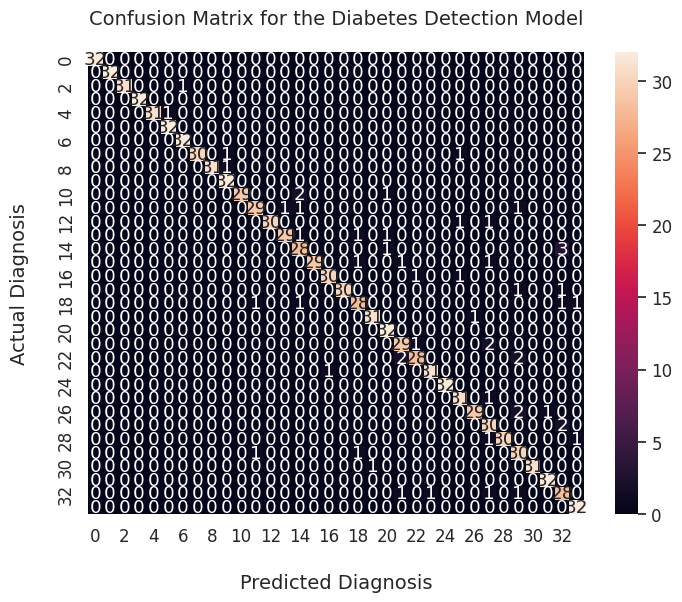

In [20]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [21]:
preds_val = model.predict(valid_generator)

33/33 [==============================] - 2s 63ms/step


In [22]:
evaluate_val = model.evaluate(valid_generator)

33/33 [==============================] - 2s 63ms/step - loss: 3.9257 - accuracy: 0.9513


In [23]:
evaluate_val

[3.925729990005493, 0.9513359069824219]

In [24]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([ 6,  0,  0, ..., 33, 33, 33])

In [25]:
y_real_val = valid_generator.classes
y_real_val

array([ 0,  0,  0, ..., 33, 33, 33], dtype=int32)

In [26]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9561068702290076

In [27]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[29,  0,  0, ...,  0,  0,  0],
       [ 0, 30,  0, ...,  0,  0,  0],
       [ 0,  0, 29, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 31,  0,  0],
       [ 0,  0,  0, ...,  0, 29,  0],
       [ 0,  0,  0, ...,  0,  0, 30]])

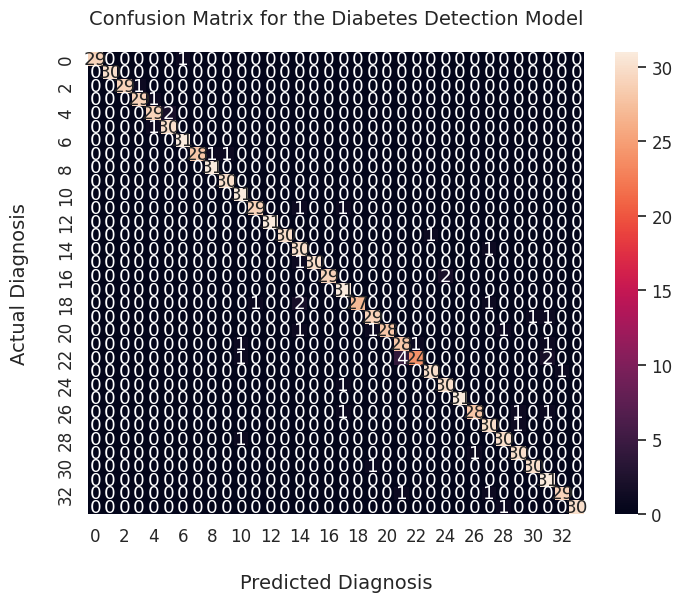

In [28]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()